In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
import cmocean.cm as cmo
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}
from matplotlib.patches import Rectangle
import json

In [2]:
def get_stuff_at_y(ht, y, mld):
    HT = ht.isel(YG=y)
    MLD = mld.isel(YG=y).values
    HT_in_ML = HT.where(HT.Z >= -MLD, other=0)
    drF_in_ML = HT.drF.where(HT.Z.values >= -MLD, other=0)
    HT_total_ML = (HT_in_ML * drF_in_ML.data).sum("Z")
    HT_out_ML = HT.where(HT.Z < -MLD, other=0)
    return MLD, HT_total_ML, HT_out_ML

In [3]:
path = "../data_for_plots/" 

In [4]:
mean = xr.open_mfdataset(path + "mean_heat_transports_0201-01-01_0300-12-30_JJA_NoML_zonal_integral.nc")
transient = xr.open_mfdataset(path + "transient_heat_transports_0201-01-01_0300-12-30_JJA_NoML_zonal_integral.nc")
isopycnal = xr.open_mfdataset(path + "isopycnal_heat_transports_0201-01-01_0300-12-30_JJA_NoML_zonal_integral.nc")

In [5]:
transient_full = xr.open_mfdataset(path + "transient_heat_transports_0201-01-01_0300-12-30_JJA_zonal_integral.nc")

In [6]:
MLD = xr.open_mfdataset(path + "MXLDEPTH_0201-01-01_0300-12-30_JJA_zonal_mean.nc").MXLDEPTH
T = xr.open_mfdataset(path + "THETA_0201-01-01_0300-12-30_JJA_zonal_mean.nc").THETA
SIG2 = xr.open_mfdataset(path + "SIG2_0201-01-01_0300-12-30_JJA_zonal_mean.nc").SIG2
MOC_res = xr.open_mfdataset(path + "MOC_res_0201-01-01_0300-12-30_JJA.nc").MOC_res
MOC_res_z = xr.open_mfdataset(path + "MOC_res_z_0201-01-01_0300-12-30_JJA.nc").MOC_res_z
T_rho = xr.open_mfdataset(path + "T_on_isopycnals_0201-01-01_0300-12-30_JJA_zonal_mean.nc")
MLDmax = xr.open_mfdataset(path + "MXLDEPTH_0201-01-01_0300-12-30_max_zonal_max.nc").MXLDEPTH

In [7]:
with open(path + 'table_of_fluxes.JJA.json', 'r', encoding='utf-8') as f: 
    tof = json.load(f)
f.close()

In [8]:
SIarea = xr.open_mfdataset(path + "SIarea_0201-01-01_0300-12-30_JJA_zonal_mean.nc")
SIheff = xr.open_mfdataset(path + "SIheff_0201-01-01_0300-12-30_JJA_zonal_mean.nc")

In [9]:
SIedge15 = len(SIarea.YC) - SIarea.SIarea.where(SIarea.SIarea <= 0.15, other=1)[::-1].argmax("YC").values
SIedge80 = len(SIarea.YC) - SIarea.SIarea.where(SIarea.SIarea <= 0.80, other=1)[::-1].argmax("YC").values

In [10]:
ML_at_190, THTdiv_ML_at_190, THTdiv_outside_ML_190 = get_stuff_at_y(
    transient.THTdiv * transient.drF * 1e16, 190, MLD)
ML_at_S15, THTdiv_ML_at_S15, THTdiv_outside_ML_S15 = get_stuff_at_y(
    transient.THTdiv * transient.drF * 1e16, SIedge15, MLD)
ML_at_S80, THTdiv_ML_at_S80, THTdiv_outside_ML_S80 = get_stuff_at_y(
    transient.THTdiv * transient.drF * 1e16, SIedge80, MLD)
ML_at_080, THTdiv_ML_at_080, THTdiv_outside_ML_080 = get_stuff_at_y(
    transient.THTdiv * transient.drF * 1e16, 80, MLD)

_, THTdiveddy_ML_at_190, THTdiveddy_outside_ML_190 = get_stuff_at_y(
    transient.THTdiveddy * transient.drF * 1e12, 190, MLD)
_, THTdiveddy_ML_at_S15, THTdiveddy_outside_ML_S15 = get_stuff_at_y(
    transient.THTdiveddy * transient.drF * 1e12, SIedge15, MLD)
_, THTdiveddy_ML_at_S80, THTdiveddy_outside_ML_S80 = get_stuff_at_y(
    transient.THTdiveddy * transient.drF * 1e12, SIedge80, MLD)
_, THTdiveddy_ML_at_080, THTdiveddy_outside_ML_080 = get_stuff_at_y(
    transient.THTdiveddy * transient.drF * 1e12, 80, MLD)

_, MHT_ML_at_190, MHT_outside_ML_190 = get_stuff_at_y(
    mean.MHT * mean.drF * 1e12, 190, MLD)
_, MHT_ML_at_S15, MHT_outside_ML_S15 = get_stuff_at_y(
    mean.MHT * mean.drF * 1e12, SIedge15, MLD)
_, MHT_ML_at_S80, MHT_outside_ML_S80 = get_stuff_at_y(
    mean.MHT * mean.drF * 1e12, SIedge80, MLD)
_, MHT_ML_at_080, MHT_outside_ML_080 = get_stuff_at_y(
    mean.MHT * mean.drF * 1e12, 80, MLD)

Some functions for the plotting

In [11]:
def axtrans(ax, var1, var2, var3, y, kwarg_dict):
    c1 = ax.plot(var1, y, color=kwarg_dict["color1"], ls=kwarg_dict["ls1"], label=kwarg_dict["label1"])
    c2 = ax.plot(var2, y, color=kwarg_dict["color2"], ls=kwarg_dict["ls2"], label=kwarg_dict["label2"])
    if (var3 != None).all():
        c3 = ax.plot(var3, y, color=kwarg_dict["color3"], ls=kwarg_dict["ls3"], label=kwarg_dict["label3"])
    ax.patch.set_facecolor("w")
    ax.patch.set_alpha(0.)
    ax.set_ylim(kwarg_dict["bottomylim"], kwarg_dict["topylim"])
    ax.set_xlim(kwarg_dict["HTxmin"], kwarg_dict["HTxmax"])
    ax.spines.top.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.set_yticks([])
    ax.grid(color=kwarg_dict["color1"], ls=":")
    ax.set_xticks(kwarg_dict["HTxticks"])
    ax.set_xticklabels(kwarg_dict["HTxticklabels"])
    ax.set_xlabel(kwarg_dict["xlabel"], color=kwarg_dict["color1"])
    ax.tick_params(axis='x', colors=kwarg_dict["color1"], labelsize=11.5)

In [12]:
def hbars(cats, vals, errs, ax, bw):
    bar = ax.barh(cats, vals, xerr=errs, align='center', color=["steelblue", "steelblue", "k"],
                  hatch=["|||", "", ""], height=bw)
    no_axes(ax)
    return bar

In [13]:
def no_axes(ax):
    ax.spines.left.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.patch.set_alpha(0)

In [14]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

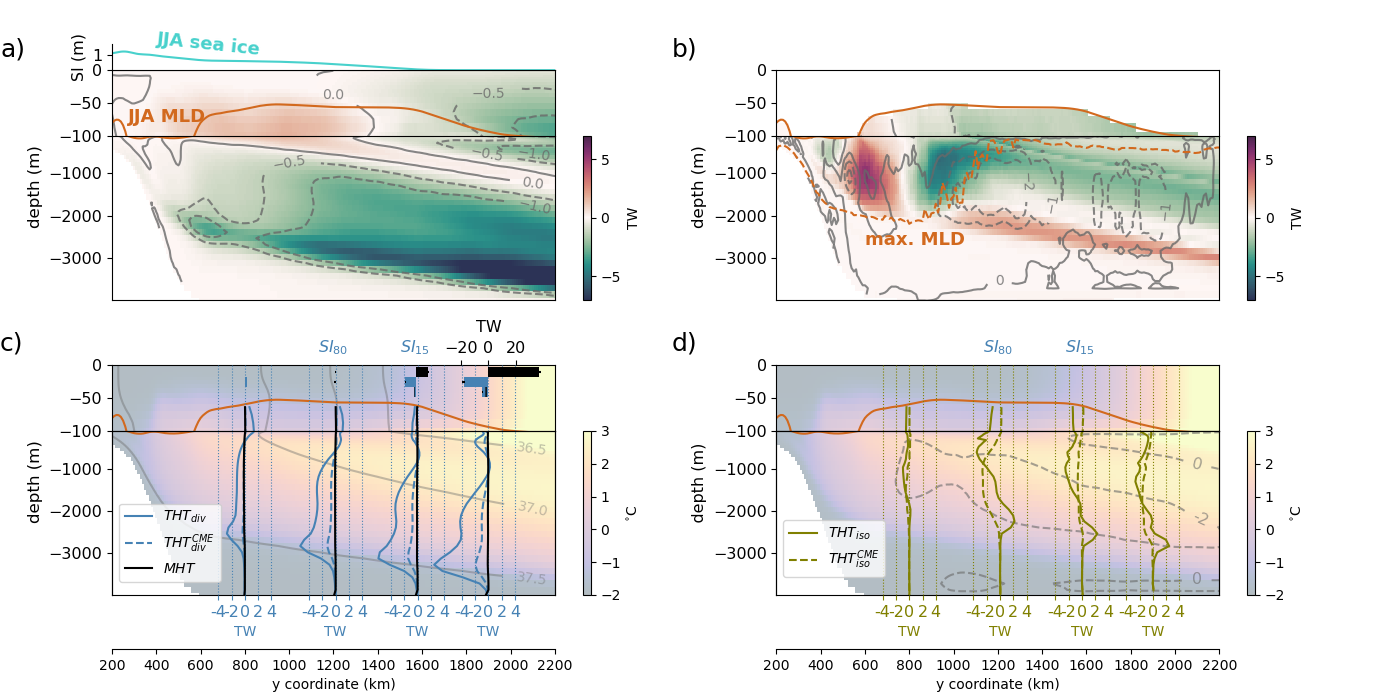

In [15]:
fig, ax = plt.subplots(5, 2, figsize=(14, 7), gridspec_kw={"height_ratios": [1, 2.5, 1, 1, 2.5]})


#############################################################################################################################################
#######  Upper subplot (HT vs z)#############################################################################################################
#############################################################################################################################################

##############################################
# set some parameters and prepare the subplots
##############################################
bottomylim = -4000
topylim = 0

ax01 = ax[1, 0]
ax0 = ax[0, 0]
axice = ax0.inset_axes([0, 1, 1, 0.4])
Dmax = 55
bottomylim=-4000
upper_lower = -100

plotlat = mean.YG.values
plotz = mean.Z.isel(Z=slice(0, Dmax+1)).values
isoplotz = isopycnal.Z.isel(Z=slice(0, Dmax+1)).values
shelfmask = (T / T).where(T != 0)

##############################################
# main part of upper subplot
##############################################
a = ax01.pcolormesh(plotlat, plotz, transient_full.THTdiv.isel(Z=slice(0, Dmax)) * shelfmask * transient_full.drF, 
                    cmap=cmo.curl, alpha=0.9, vmin=-7, vmax=7)
b = ax01.contour(plotlat, plotz, transient_full.THTdiveddy.isel(Z=slice(0, Dmax)) * shelfmask * transient_full.drF,
                 colors="dimgray", levels=[-1, -0.5, 0, 0.5, 1], alpha=0.8)
fmt = {}
strs = [int(b.levels[i] * 1e-6) for i in range(0, len(b.levels))]
for l, s in zip(b.levels, strs):
    fmt[l] = s
ax01.clabel(b, b.levels, inline=True, fontsize=10, 
            manual=[(1.9e6, -400), (2.1e6, -600), (2.1e6, -1200), (2.1e6, -2000), (1.0e6, -700)])
plt.colorbar(a, label=r"TW", ax=ax01)
c = ax01.plot(plotlat, -MLD.where(plotlat < 1e6), color="chocolate")
ax01.set_xlim(0.2e6, 2.2e6)
ax01.set_ylim(bottomylim, upper_lower)
ax01.set_ylabel("            depth (m)", fontsize=12)
ax01.set_xticks([])
ax01.set_xlabel("")
ax01.set_yticks([-3000, -2000, -1000])
ax01.spines.top.set_visible(True)
ax01.tick_params(axis='both', which='major', labelsize=11.5)

##############################################
# zoom to the upper 100 m
##############################################

a = ax0.pcolormesh(plotlat, plotz, transient_full.THTdiv.isel(Z=slice(0, Dmax)) * shelfmask * transient_full.drF, 
                    cmap=cmo.curl, alpha=0.9, vmin=-7, vmax=7)
b = ax0.contour(plotlat, plotz, transient_full.THTdiveddy.isel(Z=slice(0, Dmax)) * shelfmask * transient_full.drF,
                 colors="dimgray", levels=[-1, -0.5, 0, 0.5, 1], alpha=0.8)
fmt = {}
strs = [int(b.levels[i] * 1e-6) for i in range(0, len(b.levels))]
for l, s in zip(b.levels, strs):
    fmt[l] = s
ax0.clabel(b, b.levels, inline=True, fontsize=10, 
            manual=[(1.2e6, -30), (1.9e6, -50)])
c = ax0.plot(plotlat, (-MLD), color="chocolate")
plt.colorbar(a, label=r"$^{\circ}$C", ax=ax0)
ax0.set_xlim(0.2e6, 2.2e6)
ax0.set_ylim(upper_lower, 0)
ax0.set_xticks([])
ax0.spines.bottom.set_visible(False)
ax0.text(0.27e6, -80, "JJA MLD", fontsize=13, fontweight="bold", color="chocolate")
ax0.tick_params(axis='y', which='major', labelsize=11.5)

d = axice.plot(plotlat, SIheff.SIheff, color="mediumturquoise")
axice.set_xlim(0.2e6, 2.2e6)
axice.set_ylim(0.01, 1.7)
axice.set_yticks([1])
axice.set_xticks([])
axice.set_ylabel("SI (m)", fontsize=11.5)
axice.spines.right.set_visible(False)
axice.spines.top.set_visible(False)
axice.text(0.4e6, 1, "JJA sea ice", fontsize=13, fontweight="bold", color="mediumturquoise", rotation=-6)
axice.tick_params(axis='y', which='major', labelsize=11.5)
plt.subplots_adjust(top=0.8)

##############################################
# main part of upper subplot right
##############################################

ax11 = ax[1, 1]
ax00 = ax[0, 1]

a = ax11.pcolormesh(plotlat, plotz, 
                    isopycnal.iso_total_z.where(isopycnal.Z <= (-MLD)).isel(Z=slice(0, Dmax)).T * shelfmask * 1e-12, 
                    cmap=cmo.curl, alpha=0.9, vmin=-7, vmax=7)
b = ax11.contour(plotlat, plotz, 
                 isopycnal.iso_totaleddy_z.where(isopycnal.Z <= (-MLD)).isel(Z=slice(0, Dmax)).T * shelfmask * 1e-12,
                 colors="dimgray", levels=[-2, -1, 0, 1, 2], alpha=0.8)
fmt = {}
strs = [int(b.levels[i] * 1e-6) for i in range(0, len(b.levels))]
for l, s in zip(b.levels, strs):
    fmt[l] = s
ax11.clabel(b, b.levels, inline=True, fontsize=10, 
            manual=[(1.3e6, -1200), (1.4e6, -1700), (1.9e6, -1800), (1.2e6, -3500)])
plt.colorbar(a, label=r"TW", ax=ax11)
c = ax11.plot(plotlat, -MLD.where(plotlat < 1e6), color="chocolate")
d = ax11.plot(plotlat, (-MLDmax), color="chocolate", ls="--")
ax11.set_xlim(0.2e6, 2.2e6)
ax11.set_ylim(bottomylim, upper_lower)
ax11.set_ylabel("            depth (m)", fontsize=12)
ax11.set_xticks([])
ax11.set_xlabel("")
ax11.set_yticks([-3000, -2000, -1000])
ax11.spines.top.set_visible(True)
ax11.tick_params(axis='both', which='major', labelsize=11.5)

##############################################
# zoom to the upper 100 m
##############################################

a = ax00.pcolormesh(plotlat, plotz, 
                   isopycnal.iso_total_z.where(isopycnal.Z <= (-MLD)).isel(Z=slice(0, Dmax)).T * shelfmask * 1e-12, 
                    cmap=cmo.curl, alpha=0.9, vmin=-7, vmax=7)
b = ax00.contour(plotlat, plotz, 
                isopycnal.iso_total_z.where(isopycnal.Z <= (-MLD)).isel(Z=slice(0, Dmax)).T * shelfmask * 1e-12,
                 colors="dimgray", levels=[-2, -1, 0, 1, 2], alpha=0.8)
c = ax00.plot(plotlat, (-MLD), color="chocolate")
d = ax00.plot(plotlat, (-MLDmax), color="chocolate", ls="--")
plt.colorbar(a, label=r"$^{\circ}$C", ax=ax00)
ax00.set_xlim(0.2e6, 2.2e6)
ax00.set_ylim(upper_lower, 0)
ax00.set_xticks([])
ax00.spines.bottom.set_visible(False)
ax11.text(0.6e6, -2700, "max. MLD", fontsize=13, fontweight="bold", color="chocolate")
ax00.tick_params(axis='y', which='major', labelsize=11.5)

#############################################################################################################################################
#######  Middle subplot (HT vs z with T as background)#############################################################################################################
############################################################################################################################

ax04 = ax[4, 0]
ax03 = ax[3, 0]

a = ax04.pcolormesh(plotlat, plotz, T.isel(Z=slice(0, Dmax)) * shelfmask, 
                    cmap=cmo.thermal, alpha=0.3, vmin=-2, vmax=3)
b = ax04.contour(plotlat, plotz, (SIG2.isel(Z=slice(0, Dmax)) - 1000. * shelfmask),
                 colors="dimgray", levels=[36.5, 37.0, 37.5], alpha=0.4)
fmt = {}
strs = [int(b.levels[i] * 1e-6) for i in range(0, len(b.levels))]
for l, s in zip(b.levels, strs):
    fmt[l] = s
ax04.clabel(b, b.levels, inline=True, fontsize=10, 
            manual=[(2.1e6, -400), (2.1e6, -2000), (2.1e6, -3500)])
plt.colorbar(a, label=r"$^{\circ}$C", ax=ax04)
c = ax04.plot(plotlat, -MLD.where(plotlat < 1e6), color="chocolate")
ax04.set_xlim(0.2e6, 2.2e6)
ax04.set_ylim(bottomylim, upper_lower)
ax04.set_ylabel("            depth (m)", fontsize=12)
ax04.set_xticks([])
ax04.set_xlabel("")
ax04.set_yticks([-3000, -2000, -1000])
ax04.spines.top.set_visible(True)
ax04.tick_params(axis='both', which='major', labelsize=11.5)

# add insets for HT

HTxmin = -1e13
HTxmax = 1e13
HTxticks = [-4e12, -2e12, 0, 2e12, 4e12]
HTxticklabels = [-4, -2, 0, 2, 4]
axtrans_w = 0.3
inax190 = (190-20)/200 - (axtrans_w/2)
inaxS15 = (SIedge15-20)/200 - (axtrans_w/2)
inaxS80 = (SIedge80-20)/200 - (axtrans_w/2)
inax080 = (80-20)/200 - (axtrans_w/2)

trans_args = {"color1": "steelblue", 
              "color2": "steelblue", 
              "color3": "k",
              "ls1": "-", 
              "ls2": "--", 
              "ls3": "-",
              "label1": "$THT_{div}$",
              "label2": "$THT_{div}^{CME}$",
              "label3": "$MHT$",
              "xlabel": "TW",
              "bottomylim": bottomylim,
              "topylim": upper_lower,
              "HTxmin": HTxmin,
              "HTxmax": HTxmax,
              "HTxticks": HTxticks,
              "HTxticklabels": HTxticklabels
             }

axtrans0 = ax04.inset_axes([inax190, 0., axtrans_w, 1])
axtrans(axtrans0, THTdiv_outside_ML_190, THTdiveddy_outside_ML_190, MHT_outside_ML_190, 
        plotz, trans_args)

axtrans1 = ax04.inset_axes([inaxS15, 0., axtrans_w, 1])
axtrans(axtrans1, THTdiv_outside_ML_S15, THTdiveddy_outside_ML_S15, MHT_outside_ML_S15, 
        plotz, trans_args)

axtrans2 = ax04.inset_axes([inaxS80, 0., axtrans_w, 1])
axtrans(axtrans2, THTdiv_outside_ML_S80, THTdiveddy_outside_ML_S80, MHT_outside_ML_S80, 
        plotz, trans_args)

axtrans3 = ax04.inset_axes([inax080, 0., axtrans_w, 1])
axtrans(axtrans3, THTdiv_outside_ML_080, THTdiveddy_outside_ML_080, MHT_outside_ML_080, 
        plotz, trans_args)

axtrans3.legend(loc=2, bbox_to_anchor=(-0.5, 0.6))

##############################################
# zoom to the upper 100 m
##############################################

a = ax03.pcolormesh(plotlat, plotz, T.isel(Z=slice(0, Dmax)) * shelfmask, 
                  cmap=cmo.thermal, alpha=0.3, vmin=-2, vmax=3)
b = ax03.contour(plotlat, plotz, (SIG2.isel(Z=slice(0, Dmax)) - 1000.) * shelfmask,
               colors="dimgray", levels=[36.5, 36.75, 37.0, 37.25, 37.5], alpha=0.4)
fmt = {}
strs = [int(b.levels[i] * 1e-6) for i in range(0, len(b.levels))]
for l, s in zip(b.levels, strs):
    fmt[l] = s
c = ax03.plot(plotlat, (-MLD), color="chocolate")
plt.colorbar(a, label=r"$^{\circ}$C", ax=ax03)
ax03.set_xlim(0.2e6, 2.2e6)
ax03.set_ylim(upper_lower, 0)
ax03.set_xticks([])
ax03.spines.bottom.set_visible(False)
ax03.tick_params(axis='y', which='major', labelsize=11.5)

# add insets for HT

trans_args["topylim"] = topylim
trans_args["bottomylim"] = upper_lower

axtrans0 = ax03.inset_axes([inax190, 0., axtrans_w, 1])
axtrans(axtrans0, 
        THTdiv_outside_ML_190.where(THTdiv_outside_ML_190.Z < -MLD.isel(YG=190)), 
        THTdiveddy_outside_ML_190.where(THTdiv_outside_ML_190.Z < -MLD.isel(YG=190)), 
        MHT_outside_ML_190.where(THTdiv_outside_ML_190.Z < -MLD.isel(YG=190)), 
        plotz, trans_args)

axtrans1 = ax03.inset_axes([inaxS15, 0., axtrans_w, 1])
axtrans(axtrans1, 
        THTdiv_outside_ML_S15.where(THTdiv_outside_ML_190.Z < -MLD.isel(YG=SIedge15)), 
        THTdiveddy_outside_ML_S15.where(THTdiv_outside_ML_190.Z < -MLD.isel(YG=SIedge15)), 
        MHT_outside_ML_S15.where(THTdiv_outside_ML_190.Z < -MLD.isel(YG=SIedge15)), 
        plotz, trans_args)

axtrans2 = ax03.inset_axes([inaxS80, 0., axtrans_w, 1])
axtrans(axtrans2, 
        THTdiv_outside_ML_S80.where(THTdiv_outside_ML_190.Z < -MLD.isel(YG=SIedge80)), 
        THTdiveddy_outside_ML_S80.where(THTdiv_outside_ML_190.Z < -MLD.isel(YG=SIedge80)), 
        MHT_outside_ML_S80.where(THTdiv_outside_ML_190.Z < -MLD.isel(YG=SIedge80)), 
        plotz, trans_args)

axtrans3 = ax03.inset_axes([inax080, 0., axtrans_w, 1])
axtrans(axtrans3, 
        THTdiv_outside_ML_080.where(THTdiv_outside_ML_190.Z < -MLD.isel(YG=80)), 
        THTdiveddy_outside_ML_080.where(THTdiv_outside_ML_190.Z < -MLD.isel(YG=80)), 
        MHT_outside_ML_080.where(THTdiv_outside_ML_190.Z < -MLD.isel(YG=80)), 
        plotz, trans_args)

axice.set_title("")

# add the barplots to the mixed layer

cats = np.arange(0, 3)
hbar_width = 0.25
hbar_height_up = 0.5
xmin = -40
xmax = 40

tmp = tof["horizontal HT within ML"]["at y=80"]
vals0a = np.array([tmp["CME_mean"], tmp["transient_mean"], tmp["mean_mean"]])
errs0a = np.array([tmp["CME_std"], tmp["transient_std"], tmp["mean_std"]])
bar_ax0a = ax03.inset_axes([0.175, 0.5, hbar_width, hbar_height_up])
bar0a = hbars(cats, vals0a, errs0a, bar_ax0a, 1)
bar_ax0a.set_xlim(xmin, xmax)

tmp = tof["horizontal HT within ML"]["at 80% ice"]
vals1a = np.array([tmp["CME_mean"], tmp["transient_mean"], tmp["mean_mean"]])
errs1a = np.array([tmp["CME_std"], tmp["transient_std"], tmp["mean_std"]])
bar_ax1a = ax03.inset_axes([0.378, 0.5, hbar_width, hbar_height_up])
bar1a = hbars(cats, vals1a, errs1a, bar_ax1a, 1)
bar_ax1a.set_xlim(xmin, xmax)

tmp = tof["horizontal HT within ML"]["at 15% ice"]
vals2a = np.array([tmp["CME_mean"], tmp["transient_mean"], tmp["mean_mean"]])
errs2a = np.array([tmp["CME_std"], tmp["transient_std"], tmp["mean_std"]])
bar_ax2a = ax03.inset_axes([0.562, 0.5, hbar_width, hbar_height_up])
bar2a = hbars(cats, vals2a, errs2a, bar_ax2a, 1)
bar_ax2a.set_xlim(xmin, xmax)

tmp = tof["horizontal HT within ML"]["at y=190"]
vals3a = np.array([tmp["CME_mean"], tmp["transient_mean"], tmp["mean_mean"]])
errs3a = np.array([tmp["CME_std"], tmp["transient_std"], tmp["mean_std"]])
bar_ax3a = ax03.inset_axes([0.725, 0.5, hbar_width, hbar_height_up])
bar3a = hbars(cats, vals3a, errs3a, bar_ax3a, 1)
bar_ax3a.set_xlim(xmin, xmax)
bar_ax3a.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
bar_ax3a.set_xticks([-20, 0, 20], loc="top")
#bar_ax3a.set_xticklabels([-200, 0, 200])
bar_ax3a.set_title("TW", fontsize=11.5)
bar_ax3a.tick_params(axis='x', which='major', labelsize=11.5)

ax01.hlines(-100, 0, 3e6, lw=0.5, color="k", ls="-", zorder=99)

#############################################################################################################################################
#######  Bottom subplot (isopycnal HT vs z with T as background)#############################################################################################################
############################################################################################################################

trans_args["topylim"] = topylim
trans_args["bottomylim"] = bottomylim
trans_args["xlabel"] = "TW"
trans_args["label1"] = r"$THT_{iso}$"
trans_args["label2"] = r"$THT^{CME}_{iso}$"
trans_args["color1"] = "olive" 
trans_args["color2"] = "olive"

ax7 = ax[4, 1]
ax6 = ax[3, 1]

a = ax7.pcolormesh(plotlat, plotz, T.isel(Z=slice(0, Dmax)) * shelfmask, 
                     cmap=cmo.thermal, alpha=0.3, vmin=-2, vmax=3)
b = ax7.contour(MOC_res_z.YG, MOC_res_z.Z, -MOC_res_z.T * shelfmask.values,
                  colors="dimgray", levels=[-2e6, 0], linestyles="--", alpha=0.6)
fmt = {}
strs = [int(b.levels[i] * 1e-6) for i in range(0, len(b.levels))]
for l, s in zip(b.levels, strs):
    fmt[l] = s
ax7.clabel(b, b.levels, inline=True, fontsize=11.5, 
             manual=[(2.1e6, -900), (2.1e6, -2400), (2.1e6, -3700)], fmt=fmt)

c = ax7.plot(plotlat, -MLD.where(plotlat < 1e6), color="chocolate")
ax_lines_labels = ax7.get_legend_handles_labels()
plt.colorbar(a, label=r"$^{\circ}$C", ax=ax7)
ax7.set_xlim(0.2e6, 2.2e6)
ax7.set_ylim(bottomylim, upper_lower)
ax7.set_ylabel("            depth (m)", fontsize=11.5)
ax7.set_yticks([-3000, -2000, -1000])
#ax7.spines.top.set_visible(False)
ax7.set_xticks([])
#ax7.set_xticklabels(["y=200 km", "     y=2200 km"])
ax7.set_xlabel("")
ax7.tick_params(axis='both', which='major', labelsize=11.5)

# add insets for HT
trans_args["topylim"] = upper_lower
trans_args["bottomylim"] = bottomylim

axtrans30 = ax7.inset_axes([inax190, 0., axtrans_w, 1])
axtrans(axtrans30,
        isopycnal.iso_total_z.where(isopycnal.Z <= (-MLD)).isel(YG=190),
        isopycnal.iso_totaleddy_z.where(isopycnal.Z <= (-MLD)).isel(YG=190),
        np.array([None, None]),
        isoplotz,
        trans_args)

axtrans31 = ax7.inset_axes([inaxS15, 0., axtrans_w, 1])
axtrans(axtrans31,
        isopycnal.iso_total_z.where(isopycnal.Z <= (-MLD)).isel(YG=SIedge15),
        isopycnal.iso_totaleddy_z.where(isopycnal.Z <= (-MLD)).isel(YG=SIedge15), 
        np.array([None, None]),
        isoplotz,
        trans_args)

axtrans32 = ax7.inset_axes([inaxS80, 0., axtrans_w, 1])
axtrans(axtrans32,
        isopycnal.iso_total_z.where(isopycnal.Z <= (-MLD)).isel(YG=SIedge80),
        isopycnal.iso_totaleddy_z.where(isopycnal.Z <= (-MLD)).isel(YG=SIedge80), 
        np.array([None, None]),
        isoplotz,
        trans_args)

axtrans33 = ax7.inset_axes([inax080, 0., axtrans_w, 1])
axtrans(axtrans33,
        isopycnal.iso_total_z.where(isopycnal.Z <= (-MLD)).isel(YG=80),
        isopycnal.iso_totaleddy_z.where(isopycnal.Z <= (-MLD)).isel(YG=80),
        np.array([None, None]),
        isoplotz,
        trans_args)

axtrans33.legend(loc=2, bbox_to_anchor=(-0.5, 0.5))

ax6.text(157 * 1e4, -5600, "$SI_{15}$", color="steelblue", ha="center", fontsize=11.5)
ax6.text(120 * 1e4, -5600, "$SI_{80}$", color="steelblue", ha="center", fontsize=11.5)

a = ax6.pcolormesh(plotlat, plotz, T.isel(Z=slice(0, Dmax)) * shelfmask, 
                     cmap=cmo.thermal, alpha=0.3, vmin=-2, vmax=3)

c = ax6.plot(plotlat, -MLD, color="chocolate", label="MLD")
ax_lines_labels = ax6.get_legend_handles_labels()
plt.colorbar(a, label=r"$^{\circ}$C", ax=ax6)
ax6.set_xlim(0.2e6, 2.2e6)
ax6.set_ylim(upper_lower, 0)
ax6.set_ylabel("")
ax6.set_xlabel("")
ax6.set_xticks([])

ax6.tick_params(axis='y', which='major', labelsize=11.5)

trans_args["topylim"] = topylim
trans_args["bottomylim"] = upper_lower

axtrans50 = ax6.inset_axes([inax190, 0., axtrans_w, 1])
axtrans(axtrans50,
        isopycnal.iso_total_z.where(isopycnal.Z <= (-MLD)).isel(YG=190),
        isopycnal.iso_totaleddy_z.where(isopycnal.Z <= (-MLD)).isel(YG=190),
        np.array([None, None]),
        isoplotz,
        trans_args)

axtrans51 = ax6.inset_axes([inaxS15, 0., axtrans_w, 1])
axtrans(axtrans51,
        isopycnal.iso_total_z.where(isopycnal.Z <= (-MLD)).isel(YG=SIedge15),
        isopycnal.iso_totaleddy_z.where(isopycnal.Z <= (-MLD)).isel(YG=SIedge15), 
        np.array([None, None]),
        isoplotz,
        trans_args)

axtrans52 = ax6.inset_axes([inaxS80, 0., axtrans_w, 1])
axtrans(axtrans52,
        isopycnal.iso_total_z.where(isopycnal.Z <= (-MLD)).isel(YG=SIedge80),
        isopycnal.iso_totaleddy_z.where(isopycnal.Z <= (-MLD)).isel(YG=SIedge80), 
        np.array([None, None]),
        isoplotz,
        trans_args)

axtrans53 = ax6.inset_axes([inax080, 0., axtrans_w, 1])
axtrans(axtrans53,
        isopycnal.iso_total_z.where(isopycnal.Z <= (-MLD)).isel(YG=80),
        isopycnal.iso_totaleddy_z.where(isopycnal.Z <= (-MLD)).isel(YG=80),
        np.array([None, None]),
        isoplotz,
        trans_args)

for axx in [ax04, ax7]:
    adax1 = axx.twiny()
    adax1.spines.bottom.set_position(("axes", -0.33))
    adax1.set_xlim(220, 2200)
    adax1.set_xticks(np.linspace(200, 2200, 11))
    adax1.xaxis.tick_bottom()
    adax1.xaxis.set_label_position("bottom")
    adax1.set_xlabel("y coordinate (km)")

for axx in [ax03, ax6]:
    axx.text(157 * 1e4, 20, "$SI_{15}$", color="steelblue", ha="center", fontsize=11.5)
    axx.text(120 * 1e4, 20, "$SI_{80}$", color="steelblue", ha="center", fontsize=11.5)

plt.subplots_adjust(bottom=0.15, top=0.9, left=0.08, right=0.95, hspace=0.0, wspace=0.2)
no_axes(ax[2, 0])
no_axes(ax[2, 1])

fig.text(0.0, 0.92, "a)", fontsize=18)
fig.text(0.0, 0.5, "c)", fontsize=18)
fig.text(0.48, 0.92, "b)", fontsize=18)
fig.text(0.48, 0.5, "d)", fontsize=18)

fig.delaxes(fig.axes[11])
fig.delaxes(fig.axes[12])
fig.delaxes(fig.axes[13])
fig.delaxes(fig.axes[14])
fig.axes[7].tick_params(axis="y", labelsize=11.5)

plt.savefig("fig07-combined_z_dependence.png", dpi=300)